In [ ]:
!pip install gym[atari,accept-rom-license]
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The state space is: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
The action space is: Box(-1.0, 1.0, (1,), float32)


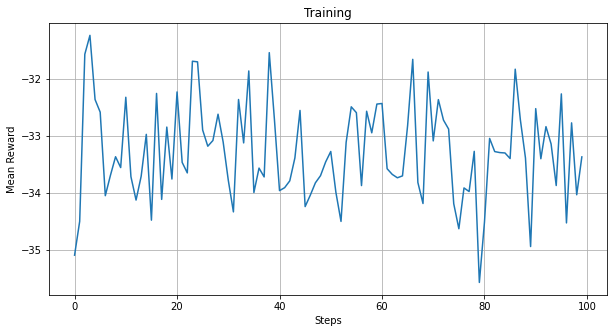

In [ ]:
#Question 1a - MountainCarContinuous-v0

import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np 
import time

import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def plot(rewards):
    fig = plt.figure(figsize=(10,5)) 

    plt.plot(rewards)
    plt.title('Training')
    plt.xlabel('Steps')
    plt.ylabel('Mean Reward')
    plt.grid()
    plt.show()

def select_action(state):
    global steps_done
    steps_done += 1
    return np.random.uniform(env.action_space.low[0],env.action_space.high[0])

def get_state(obs, prev_state=None):
    state = np.array(obs)
    state = torch.from_numpy(state).type(torch.FloatTensor)
    return state.unsqueeze(0)

def train(env, n_episodes):
    rewards = []

    successes = 0
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = select_action(state)
            obs, reward, done, info = env.step([action])
            next_state =  get_state(obs)
            total_reward += reward

            state = next_state

            if done:
                if obs[0] >= 0.5:
                    successes +=1
                break
        rewards.append(total_reward)
        #print('Total steps: {} \t Episode: {}/{} \t Total reward: {} \t Success {}'.format(steps_done, episode, t, total_reward, successes))
    env.close()
    plot(rewards)
    return

device = torch.device("cpu")
NUM_EPISODES = 100

steps_done = 0

# create environment
env = gym.make('MountainCarContinuous-v0')

state_space = env.observation_space
action_space = env.action_space
print("The state space is: {}".format(state_space))
print("The action space is: {}".format(action_space))
    
# train model
train(env, NUM_EPISODES)

The state space is: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
The action space is: Box(-1.0, 1.0, (2,), float32)


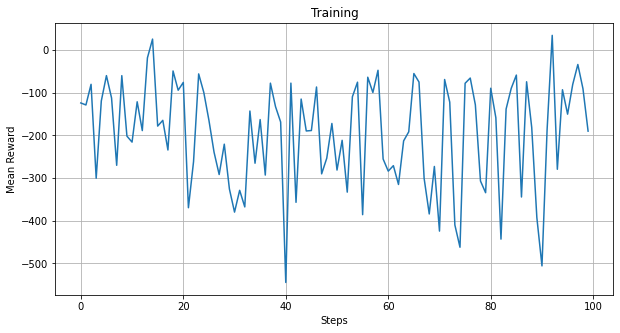

In [ ]:
#Question 1a - LunarLanderContinuous-v2

import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np 
import time

import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def plot(rewards):
    fig = plt.figure(figsize=(10,5)) 

    plt.plot(rewards)
    plt.title('Training')
    plt.xlabel('Steps')
    plt.ylabel('Mean Reward')
    plt.grid()
    plt.show()

def select_action(state):
    global steps_done
    steps_done += 1
    return [np.random.uniform(env.action_space.low[0],env.action_space.high[0]),np.random.uniform(env.action_space.low[1],env.action_space.high[1])]

def get_state(obs, prev_state=None):
    state = np.array(obs)
    state = torch.from_numpy(state).type(torch.FloatTensor)
    return state.unsqueeze(0)

def train(env, n_episodes):
    rewards = []

    successes = 0
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = select_action(state)
            obs, reward, done, info = env.step(action)
            next_state =  get_state(obs)
            total_reward += reward

            state = next_state

            if done:
                if obs[0] >= 0.5:
                    successes +=1
                break
        rewards.append(total_reward)
        #print('Total steps: {} \t Episode: {}/{} \t Total reward: {} \t Success {}'.format(steps_done, episode, t, total_reward, successes))
    env.close()
    plot(rewards)
    return

device = torch.device("cpu")
NUM_EPISODES = 100

steps_done = 0

# create environment
env = gym.make('LunarLanderContinuous-v2')

state_space = env.observation_space
action_space = env.action_space
print("The state space is: {}".format(state_space))
print("The action space is: {}".format(action_space))
    
# train model
train(env, NUM_EPISODES)

Question 1a
1. **Mountain Car Continuous-v0 :** 
- Action space : A real number between -1 and 1.
- State space : A tuple of 2 real numbers. The first one represents the car's position and the second one represents the car's velocity.
- Reward function : -1 is awarded for each time step spent. +100 is awarded when the agent reaches the goal state.

2. **Lunar Lander Continuous-v2 :**
- Action space : A tuple of 2 real numbers, each between -1 and 1.
- State space : A tuple of 8 real numbers. The first two of them represent the coordinate of the agent. The remaining represent data such as velocity, acceleration etc.
- Reward function : +100 if agent comes to rest. -100 if agent crashes. +10 for each leg contact. +200 if the environment is solved. -0.3 for firing each of the engines for a time frame.

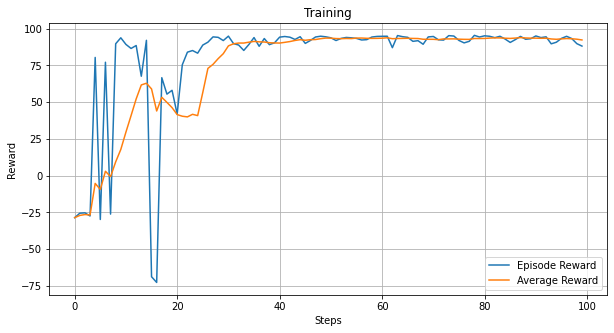

In [ ]:
#Question 1b - MountainCarContinuous-v0

import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np 
import time
from collections import deque
import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def plot(rewards,avg_rewards):
    fig = plt.figure(figsize=(10,5)) 

    plt.plot(rewards,label='Episode Reward')
    plt.plot(avg_rewards,label='Average Reward')
    plt.title('Training')
    plt.xlabel('Steps')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend()

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x

class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0): 
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    action = actor(state)
    action = action.detach().numpy()[0,0]
    return action
    
def optimize_model():
    states, actions, rewards, next_states, _ = memory.sample(BATCH_SIZE)
    states = torch.FloatTensor(states)
    actions = torch.FloatTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    
    # Critic loss        
    Qvals = critic(states, actions)
    next_actions = target_actor(next_states)
    next_Q = target_critic(next_states, next_actions.detach())
    Qprime = rewards + GAMMA* next_Q
    critic_loss = F.mse_loss(Qvals, Qprime)

    # Actor loss
    policy_loss = -critic(states, actor(states)).mean()
        
    # update networks
    actor_optimizer.zero_grad()
    policy_loss.backward()
    actor_optimizer.step()

    critic_optimizer.zero_grad()
    critic_loss.backward() 
    critic_optimizer.step()

    # update target networks 
    for target_param, param in zip(target_actor.parameters(), actor.parameters()):
        target_param.data.copy_(param.data *TAU + target_param.data * (1.0 - TAU))
       
    for target_param, param in zip(target_critic.parameters(), critic.parameters()):
        target_param.data.copy_(param.data *TAU + target_param.data * (1.0 - TAU))

def get_state(obs, prev_state=None):
    state = np.array(obs)
    state = torch.from_numpy(state).type(torch.FloatTensor)
    return state.unsqueeze(0)

def train(env, n_episodes):
    rewards = []
    avg_rewards = []
    t = 0
    for episode in range(n_episodes):
        state = env.reset()
        noise.reset()
        episode_reward = 0
    
        for step in range(1000):
            action = select_action(state)
            action = noise.get_action(action, t)
            t += 1
            new_state, reward, done, _ = env.step(action) 
            memory.push(state, action, reward, new_state, done)
        
            if len(memory) > BATCH_SIZE:
                optimize_model()        
        
            state = new_state
            episode_reward += reward

            if done:
                break
        #print("Episode: {}, Reward: {:3f}".format(episode, episode_reward))
        rewards.append(episode_reward)
        avg_rewards.append(np.mean(rewards[-10:]))
    plot(rewards,avg_rewards)
    np.save('./res_ou.npy',{0:rewards,1:avg_rewards})
    return

# hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
MEMORY_SIZE = 50000
NUM_EPISODES = 100
TAU = 0.01
env = gym.make('MountainCarContinuous-v0')
noise = OUNoise(env.action_space)

# create networks
actor = Actor(env.observation_space.shape[0], 256, env.action_space.shape[0])
target_actor = Actor(env.observation_space.shape[0], 256, env.action_space.shape[0])
target_actor.load_state_dict(actor.state_dict())

critic = Critic(env.observation_space.shape[0] + env.action_space.shape[0], 256 )
target_critic = Critic(env.observation_space.shape[0] + env.action_space.shape[0], 256 )
target_critic.load_state_dict(critic.state_dict())

# setup optimizer
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

# initialize replay memory
memory = ReplayMemory(MEMORY_SIZE)
    
# train model
train(env, NUM_EPISODES)

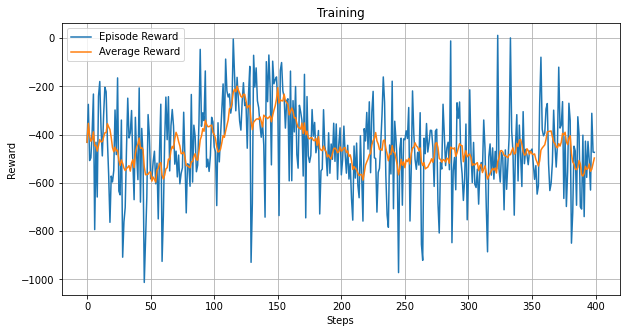

In [ ]:
#Question 1b - LunarLanderContinuous-v2

import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np 
import time
from collections import deque
import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def plot(rewards,avg_rewards):
    fig = plt.figure(figsize=(10,5)) 

    plt.plot(rewards,label='Episode Reward')
    plt.plot(avg_rewards,label='Average Reward')
    plt.title('Training')
    plt.xlabel('Steps')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend()

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x

class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0): 
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    action = actor(state)
    action = action.detach().numpy()[0,0]
    return action
    
def optimize_model():
    states, actions, rewards, next_states, _ = memory.sample(BATCH_SIZE)
    states = torch.FloatTensor(states)
    actions = torch.FloatTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    
    # Critic loss        
    Qvals = critic(states, actions)
    next_actions = target_actor(next_states)
    next_Q = target_critic(next_states, next_actions.detach())
    Qprime = rewards + GAMMA* next_Q
    critic_loss = F.mse_loss(Qvals, Qprime)

    # Actor loss
    policy_loss = -critic(states, actor(states)).mean()
        
    # update networks
    actor_optimizer.zero_grad()
    policy_loss.backward()
    actor_optimizer.step()

    critic_optimizer.zero_grad()
    critic_loss.backward() 
    critic_optimizer.step()

    # update target networks 
    for target_param, param in zip(target_actor.parameters(), actor.parameters()):
        target_param.data.copy_(param.data *TAU + target_param.data * (1.0 - TAU))
       
    for target_param, param in zip(target_critic.parameters(), critic.parameters()):
        target_param.data.copy_(param.data *TAU + target_param.data * (1.0 - TAU))

def get_state(obs, prev_state=None):
    state = np.array(obs)
    state = torch.from_numpy(state).type(torch.FloatTensor)
    return state.unsqueeze(0)

def train(env, n_episodes):
    rewards = []
    avg_rewards = []

    for episode in range(n_episodes):
        state = env.reset()
        noise.reset()
        episode_reward = 0
    
        for step in count():
            action = select_action(state)
            action = noise.get_action(action, step)
            new_state, reward, done, _ = env.step(action) 
            memory.push(state, action, reward, new_state, done)
        
            if len(memory) > BATCH_SIZE:
                optimize_model()        
        
            state = new_state
            episode_reward += reward

            if done:
                break
        #print("Episode: {}, Reward: {:3f}".format(episode, episode_reward))
        rewards.append(episode_reward)
        avg_rewards.append(np.mean(rewards[-10:]))
    plot(rewards,avg_rewards)
    return

# hyperparameters
BATCH_SIZE = 512
GAMMA = 0.9
MEMORY_SIZE = 50000
NUM_EPISODES = 400
TAU = 0.01
env = gym.make('LunarLanderContinuous-v2')
noise = OUNoise(env.action_space)

# create networks
actor = Actor(env.observation_space.shape[0], 512, env.action_space.shape[0])
target_actor = Actor(env.observation_space.shape[0], 512, env.action_space.shape[0])
target_actor.load_state_dict(actor.state_dict())

critic = Critic(env.observation_space.shape[0] + env.action_space.shape[0], 256 )
target_critic = Critic(env.observation_space.shape[0] + env.action_space.shape[0], 256 )
target_critic.load_state_dict(critic.state_dict())

# setup optimizer
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

# initialize replay memory
memory = ReplayMemory(MEMORY_SIZE)
    
# train model
train(env, NUM_EPISODES)

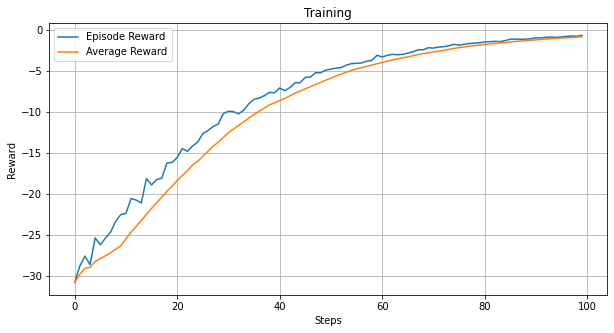

In [ ]:
#Question 1c

import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np 
import time
from collections import deque
import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def plot(rewards,avg_rewards):
    fig = plt.figure(figsize=(10,5)) 

    plt.plot(rewards,label='Episode Reward')
    plt.plot(avg_rewards,label='Average Reward')
    plt.title('Training')
    plt.xlabel('Steps')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend()

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x

class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

class GaussNoise(object):
    def __init__(self, action_space, mu=0.0, sigma=0.6, decay_period=50000.0):
        self.mu           = mu
        self.sigma        = sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        pass
    
    def get_action(self, action, t=0): 
        noise = np.exp(-t/self.decay_period)*np.random.normal(self.mu,self.sigma,self.action_dim)
        return np.clip(action + noise, self.low, self.high)

def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    action = actor(state)
    action = action.detach().numpy()[0,0]
    return action
    
def optimize_model():
    states, actions, rewards, next_states, _ = memory.sample(BATCH_SIZE)
    states = torch.FloatTensor(states)
    actions = torch.FloatTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    
    # Critic loss        
    Qvals = critic(states, actions)
    next_actions = target_actor(next_states)
    next_Q = target_critic(next_states, next_actions.detach())
    Qprime = rewards + GAMMA* next_Q
    critic_loss = F.mse_loss(Qvals, Qprime)

    # Actor loss
    policy_loss = -critic(states, actor(states)).mean()
        
    # update networks
    actor_optimizer.zero_grad()
    policy_loss.backward()
    actor_optimizer.step()

    critic_optimizer.zero_grad()
    critic_loss.backward() 
    critic_optimizer.step()

    # update target networks 
    for target_param, param in zip(target_actor.parameters(), actor.parameters()):
        target_param.data.copy_(param.data *TAU + target_param.data * (1.0 - TAU))
       
    for target_param, param in zip(target_critic.parameters(), critic.parameters()):
        target_param.data.copy_(param.data *TAU + target_param.data * (1.0 - TAU))

def get_state(obs, prev_state=None):
    state = np.array(obs)
    state = torch.from_numpy(state).type(torch.FloatTensor)
    return state.unsqueeze(0)

def train(env, n_episodes):
    rewards = []
    avg_rewards = []
    t = 0
    for episode in range(n_episodes):
        state = env.reset()
        noise.reset()
        episode_reward = 0
    
        for step in range(1000):
            action = select_action(state)
            action = noise.get_action(action, t)
            t += 1
            new_state, reward, done, _ = env.step(action) 
            memory.push(state, action, reward, new_state, done)
        
            if len(memory) > BATCH_SIZE:
                optimize_model()        
        
            state = new_state
            episode_reward += reward

            if done:
                break
        #print("Episode: {}, Reward: {:3f}".format(episode, episode_reward))
        rewards.append(episode_reward)
        avg_rewards.append(np.mean(rewards[-10:]))
    plot(rewards,avg_rewards)
    np.save('./res_gauss.npy',{0:rewards,1:avg_rewards})
    return

# hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
MEMORY_SIZE = 50000
NUM_EPISODES = 100
TAU = 0.01
env = gym.make('MountainCarContinuous-v0')
noise = GaussNoise(env.action_space)

# create networks
actor = Actor(env.observation_space.shape[0], 256, env.action_space.shape[0])
target_actor = Actor(env.observation_space.shape[0], 256, env.action_space.shape[0])
target_actor.load_state_dict(actor.state_dict())

critic = Critic(env.observation_space.shape[0] + env.action_space.shape[0], 256 )
target_critic = Critic(env.observation_space.shape[0] + env.action_space.shape[0], 256 )
target_critic.load_state_dict(critic.state_dict())

# setup optimizer
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

# initialize replay memory
memory = ReplayMemory(MEMORY_SIZE)
    
# train model
train(env, NUM_EPISODES)

Question 1c

On using Gaussian noise process for exploration, the agent takes much more time to converge in the given environments. This is because of the following reasons : 
- The noise created in an OU process is correlated over time steps, whereas that in Gaussian is not. 

- In the case of zero mean Gaussian noise process, the sum of the exploration terms becomes zero after some time steps, but the same does not happen with the OU noise process, thus making OU noise more suitable for exploration.

In [ ]:
#Question 2a

import numpy as np
from matplotlib import pyplot as plt

#Defining the parameters
K = 10
N = 1000
M = 10

#Means of the gaussian rewards
mu = np.arange(K)-5
np.random.shuffle(mu)
print("The means of the gaussian reward distributions are :",mu)

arm_rewards = []
for k in range(K):
  arm_rewards.append(np.random.normal(mu[k],1))
print("The rewards obtained for above gaussian reward distributions are :",arm_rewards)

The means of the gaussian reward distributions are : [-2  1 -4  4 -5  3 -3 -1  2  0]
The rewards obtained for above gaussian reward distributions are : [-1.3353928200767369, 0.9282037123756223, -3.4032821136336966, 5.228829767507327, -4.905124822941458, 4.070015666793248, -2.695728820218218, -1.460089128562569, 1.8689421641997812, -1.1233064197090412]


In [ ]:
#Question 2b

import numpy as np
from matplotlib import pyplot as plt

#Function to take greedy action
def greedy(x):
    return np.argmax(x)

#Function to take epsilon greedy action
def eps_greedy(x,eps):
    ch = np.random.choice([0,1],p = [eps,1-eps])
    if(ch==0):
        return np.random.randint(K)
    else:
        return np.argmax(x)

#Function to take action according to UCB
def UCB(x,N,t):
    temp = np.sqrt((2*np.log(t+1))/(N+1e-10))
    return np.argmax(x+temp)

#Greedy Algorithm
Q1 = np.zeros(K)
num1 = np.zeros(K)
for m in range(M):
    for k in range(K):
        reward = np.random.normal(mu[k],1)
        num1[k]+=1
        Q1[k] = Q1[k] + (1/num1[k])*(reward - Q1[k])
for m in range(M+1,N):
    ind = greedy(Q1)
    num1[ind]+=1
    reward = np.random.normal(mu[ind],1)
    Q1[ind] = Q1[ind] + (1/num1[ind])*(reward - Q1[ind])
#print("The Q values calculated are :",Q1)

#Epsilon Greedy algorithm with epsilon = 0.1
Q2 = np.zeros(K)
num2 = np.zeros(K)
for m in range(M):
    for k in range(K):
        reward = np.random.normal(mu[k],1)
        num2[k]+=1
        Q2[k] = Q2[k] + (1/num2[k])*(reward - Q2[k])
for m in range(M+1,N):
    ind = eps_greedy(Q2,0.1)
    num2[ind]+=1
    reward = np.random.normal(mu[ind],1)
    Q2[ind] = Q2[ind] + (1/num2[ind])*(reward - Q2[ind])
#print("The Q values calculated are :",Q2)

#Epsilon Greedy algorithm with epsilon = 0.01
Q3 = np.zeros(K)
num3 = np.zeros(K)
for m in range(M):
    for k in range(K):
        reward = np.random.normal(mu[k],1)
        num3[k]+=1
        Q3[k] = Q3[k] + (1/num3[k])*(reward - Q3[k])
for m in range(M+1,N):
    ind = eps_greedy(Q3,0.01)
    num3[ind]+=1
    reward = np.random.normal(mu[ind],1)
    Q3[ind] = Q3[ind] + (1/num3[ind])*(reward - Q3[ind])
#print("The Q values calculated are :",Q3)

#Epsilon Greedy with decay
Q4 = np.zeros(K)
num4 = np.zeros(K)
for m in range(M):
    for k in range(K):
        reward = np.random.normal(mu[k],1)
        num4[k]+=1
        Q4[k] = Q4[k] + (1/num4[k])*(reward - Q4[k])
r = 0.99  #Decay factor
eps = 0.1
for m in range(M+1,N):
    ind = eps_greedy(Q4,eps)
    eps = eps*0.99
    num4[ind]+=1
    reward = np.random.normal(mu[ind],1)
    Q4[ind] = Q4[ind] + (1/num4[ind])*(reward - Q4[ind])
#print("The Q values calculated are :",Q4)

#UCB algorithm
Q5 = np.zeros(K)
num5 = np.zeros(K)
for m in range(M):
    for k in range(K):
        reward = np.random.normal(mu[k],1)
        num5[k]+=1
        Q5[k] = Q5[k] + (1/num5[k])*(reward - Q5[k])
for m in range(M+1,N):
    ind = UCB(Q5,num5,m)
    num5[ind]+=1
    reward = np.random.normal(mu[ind],1)
    Q5[ind] = Q5[ind] + (1/num5[ind])*(reward - Q5[ind])
#print("The Q values calculated are :",Q5)

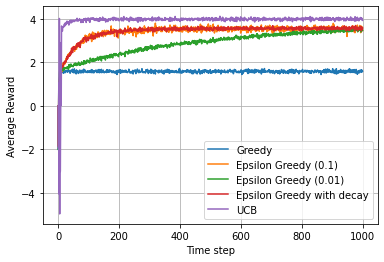

In [ ]:
#Question 2c

import numpy as np
from matplotlib import pyplot as plt

#Function for computing V*
def find_v():
    res = []
    for i in range(K):
        res.append(np.random.normal(mu[i],1))
    return max(res)

#Defining the parameters and variables and implementing the algorithms
N = 1000
T = 500  
r = 0.99
R1 = np.zeros([T,N])
R2 = np.zeros([T,N])
R3 = np.zeros([T,N])
R4 = np.zeros([T,N])
R5 = np.zeros([T,N])
rew1 = np.zeros([T,N])
rew2 = np.zeros([T,N])
rew3 = np.zeros([T,N])
rew4 = np.zeros([T,N])
rew5 = np.zeros([T,N])
V = np.zeros([T,N])
N1 = np.zeros([T,K])
N2 = np.zeros([T,K])
N3 = np.zeros([T,K])
N4 = np.zeros([T,K])
N5 = np.zeros([T,K])
n1 = np.zeros([T,N])
n2 = np.zeros([T,N])
n3 = np.zeros([T,N])
n4 = np.zeros([T,N])
n5 = np.zeros([T,N])
for t in range(T):
    q1 = np.zeros(K)
    q2 = np.zeros(K)
    q3 = np.zeros(K)
    q4 = np.zeros(K)
    q5 = np.zeros(K)
    eps = 0.1
    for n in range(1,N):
        V[t,n] = find_v()
        
        ind = greedy(q1)  #Greedy algorithm
        N1[t][ind]+=1
        n1[t][n] = N1[t][ind]
        reward = np.random.normal(mu[ind],1)
        q1[ind] = q1[ind] + (1/N1[t][ind])*(reward - q1[ind])
        R1[t,n] = R1[t,n-1] + (1/(n))*(reward - R1[t,n-1])
        rew1[t,n] = reward
        
        ind = eps_greedy(q2,0.1) #Epsilon greedy with epsilon = 0.1
        N2[t][ind]+=1
        n2[t][n] = N2[t][ind]
        reward = np.random.normal(mu[ind],1)
        q2[ind] = q2[ind] + (1/N2[t][ind])*(reward - q2[ind])
        R2[t,n] = R2[t,n-1] + (1/(n))*(reward - R2[t,n-1])
        rew2[t,n] = reward
        
        ind = eps_greedy(q3,0.01)  #Epsilon greedy with epsilon = 0.01
        N3[t][ind]+=1
        n3[t][n] = N3[t][ind]
        reward = np.random.normal(mu[ind],1)
        q3[ind] = q3[ind] + (1/N3[t][ind])*(reward - q3[ind])
        R3[t,n] = R3[t,n-1] + (1/(n))*(reward - R3[t,n-1])
        rew3[t,n] = reward
        
        ind = eps_greedy(q4,eps)  #Epsilon greedy with decay
        eps = eps*0.99
        N4[t][ind]+=1
        n4[t][n] = N4[t][ind]
        reward = np.random.normal(mu[ind],1)
        q4[ind] = q4[ind] + (1/N4[t][ind])*(reward - q4[ind])
        R4[t,n] = R4[t,n-1] + (1/(n))*(reward - R4[t,n-1])
        rew4[t,n] = reward
        
        ind = UCB(q5,N5[t],t)  #Upper confidence bound
        N5[t][ind]+=1
        n5[t][n] = N5[t][ind]
        reward = np.random.normal(mu[ind],1)
        q5[ind] = q5[ind] + (1/N5[t][ind])*(reward - q5[ind])
        R5[t,n] = R5[t,n-1] + (1/(n))*(reward - R5[t,n-1])
        rew5[t,n] = reward
        
r1 = np.mean(R1,axis=0)
r2 = np.mean(R2,axis=0)
r3 = np.mean(R3,axis=0)
r4 = np.mean(R4,axis=0)
r5 = np.mean(R5,axis=0)
rr1 = np.mean(rew1,axis=0)
rr2 = np.mean(rew2,axis=0)
rr3 = np.mean(rew3,axis=0)
rr4 = np.mean(rew4,axis=0)
rr5 = np.mean(rew5,axis=0)
v = np.mean(V,axis=0)

#Plotting the average reward per time step for different algorithms
plt.plot(rr1, label = "Greedy")
plt.plot(rr2, label = "Epsilon Greedy (0.1)")
plt.plot(rr3, label = "Epsilon Greedy (0.01)")
plt.plot(rr4, label = "Epsilon Greedy with decay")
plt.plot(rr5, label = "UCB")
plt.xlabel('Time step')
plt.ylabel('Average Reward')
plt.legend()
plt.grid()
plt.show()

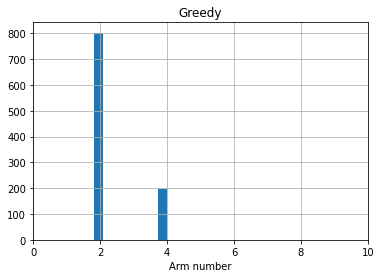

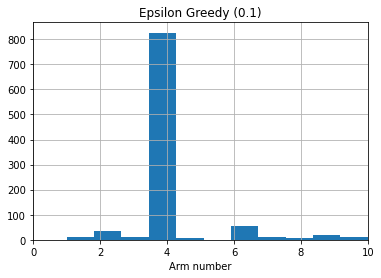

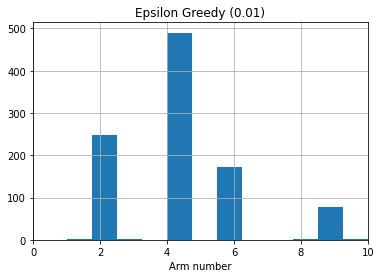

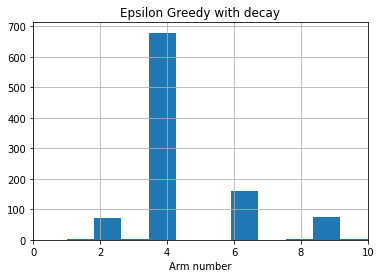

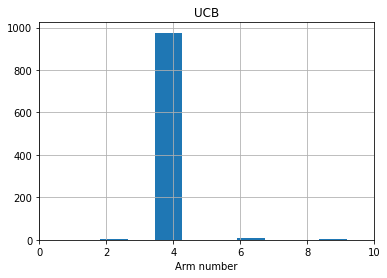

In [ ]:
#Question 2d

import numpy as np
from matplotlib import pyplot as plt

#Function useful while plotting histograms
def conv(x):
    res = []
    for i in range(0,x.shape[0]):
        for j in range(0,int(x[i])):
            res.append(i+1)
    return np.array(res)

#Greedy algorithm
a1 = np.mean(N1,axis=0)
a1 = conv(a1)
plt.hist(a1,bins = 'auto')
plt.xlim(0,10)
plt.xlabel("Arm number")
plt.title("Greedy")
plt.grid()
plt.show()

#Epsilon greedy with epsilon = 0.1
a2 = np.mean(N2,axis=0)
a2 = conv(a2)
plt.hist(a2,bins = 'auto')
plt.xlim(0,10)
plt.xlabel("Arm number")
plt.title("Epsilon Greedy (0.1)")
plt.grid()
plt.show()

#Epsilon greedy with epsilon = 0.01
a3 = np.mean(N3,axis=0)
a3 = conv(a3)
plt.hist(a3,bins = 'auto')
plt.xlim(0,10)
plt.xlabel("Arm number")
plt.title("Epsilon Greedy (0.01)")
plt.grid()
plt.show()

#Epsilon greedy with decay
a4 = np.mean(N4,axis=0)
a4 = conv(a4)
plt.hist(a4,bins = 'auto')
plt.xlim(0,10)
plt.xlabel("Arm number")
plt.title("Epsilon Greedy with decay")
plt.grid()
plt.show()

#UCB
a5 = np.mean(N5,axis=0)
a5 = conv(a5)
plt.hist(a5,bins = 'auto')
plt.xlim(0,10)
plt.xlabel("Arm number")
plt.title("UCB")
plt.grid()
plt.show()

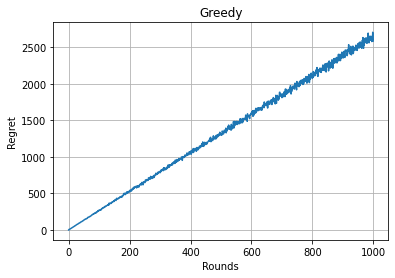

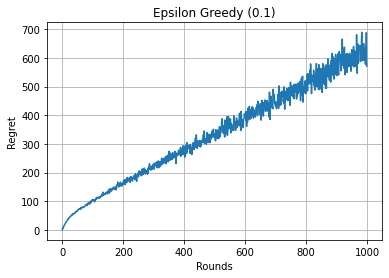

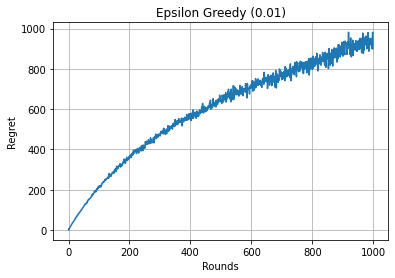

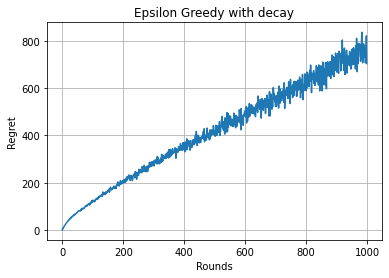

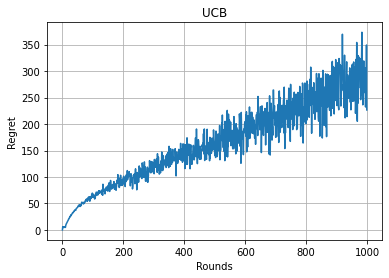

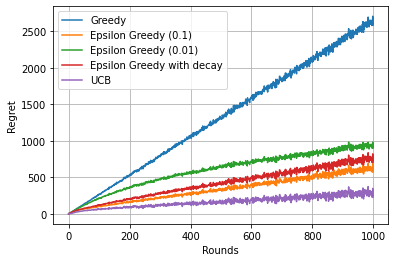

In [ ]:
#Question 2e

import numpy as np
from matplotlib import pyplot as plt

#Plotting regret for greedy algorithm
regret1 = np.mean(n1,axis=0)*(v-r1)
plt.plot(regret1)
plt.xlabel('Rounds')
plt.ylabel('Regret')
plt.title('Greedy')
plt.grid()
plt.show()

#Plotting regret for epsilon greedy algorithm with epsilon = 0.1
regret2 = np.mean(n2,axis=0)*(v-r2)
plt.plot(regret2)
plt.xlabel('Rounds')
plt.ylabel('Regret')
plt.title('Epsilon Greedy (0.1)')
plt.grid()
plt.show()

#Plotting regret for epsilon greedy algorithm with epsilon = 0.01
regret3 = np.mean(n3,axis=0)*(v-r3)
plt.plot(regret3)
plt.xlabel('Rounds')
plt.ylabel('Regret')
plt.title('Epsilon Greedy (0.01)')
plt.grid()
plt.show()

#Plotting regret for greedy with decay algorithm
regret4 = np.mean(n4,axis=0)*(v-r4)
plt.plot(regret4)
plt.xlabel('Rounds')
plt.ylabel('Regret')
plt.title('Epsilon Greedy with decay')
plt.grid()
plt.show()

#Plotting regret for UCB algorithm
regret5 = np.mean(n5,axis=0)*(v-r5)
plt.plot(regret5)
plt.xlabel('Rounds')
plt.ylabel('Regret')
plt.title('UCB')
plt.grid()
plt.show()

#Plotting a combined graph for all the regrets
plt.plot(regret1,label='Greedy')
plt.plot(regret2,label='Epsilon Greedy (0.1)')
plt.plot(regret3,label='Epsilon Greedy (0.01)')
plt.plot(regret4,label='Epsilon Greedy with decay')
plt.plot(regret5,label='UCB')
plt.xlabel('Rounds')
plt.ylabel('Regret')
plt.legend()
plt.grid()
plt.show()

Question 2f

From the above plots in question 2e, we can easily see that UCB (upper condition bound) algorithm gives the **least** regret which means that it is the best performing algorithm. This is because in UCB algorithm, we pick the arm about which we are the most unsure of. Therefore, very soon, the algorithm explores all the options available and learns to select the right arm. Conversely, we can see that greedy algorithm gives the **highest** regret (which means that it is the worst performing algorithm) as there is very less chance of exploration. Epsilon greedy algorithm performs better than Greedy algorithm and epsilon greedy with decay algorithm performs better than epsilon greedy algorithm.

Question 2g

When we take the mean value of reward of the best and second best arm to be very close, some algorithms such as epsilon greedy with epsilon equal to 0.01 is not able to clearly differentiate between the best and second best arm. Just like the previous cases, greedy algorithm is not able to find the best action here, as well. However, UCB seems to perform comparatively better than the other algorithms. In this case, the second best arm is also picked many times by all the algorithms.